In [1]:
import lsdb
lsdb.__version__

'0.2.7.dev32+g71a99a2'

# Demo: LSDB with Nested-Dask Integration

Uses the "nested" branch of LSDB.

Let's start by loading in from the Half Degree Survey datasets. We'll grab ZTF Object+Source, and PS1 Source.

In [2]:
path = "https://epyc.astro.washington.edu/~lincc-frameworks/half_degree_surveys"

ztf_obj = lsdb.read_hipscat(path + "/ztf/ztf_object/", columns=["ps1_objid", "ra", "dec"]) # ztf objects
ztf_src = lsdb.read_hipscat(path + "/ztf/ztf_source/") # ztf sources
ps1_src = lsdb.read_hipscat(path + "/ps1/ps1_source/") # panstarrs sources

We then can use `join_nested` to nest both ZTF and PS1 sources within ZTF Object.

> **_TODO:_**  We need to set suffixes to be empty strings here to avoid the default join behavior of appending suffixes to the column names. We should have empty suffixes be the default.

In [3]:
# Nesting Sources into Object
ndf = ztf_obj.join_nested(ztf_src, left_on="ps1_objid", right_on="ps1_objid", nested_column_name="ztf_sources", suffixes=("",""))
ndf = ndf.join_nested(ps1_src, left_on="ps1_objid", right_on="objID", nested_column_name="ps1_sources", suffixes=("",""))
ndf

/Users/dbranton/lincc/lsdb/src/lsdb/dask/join_catalog_data.py:298: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/Users/dbranton/lincc/lsdb/src/lsdb/dask/join_catalog_data.py:298: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ps1_objid,ra,dec,ztf_sources,ps1_sources
npartitions=4,,,,,
7799953079628988416,int64[pyarrow],double[pyarrow],double[pyarrow],"nested<index: [int64], ra: [double], dec: [dou...","nested<uniquePspsP2id: [int64], detectID: [int..."
7812056503627546624,...,...,...,...,...
7824159927626104832,...,...,...,...,...
7836263351624663040,...,...,...,...,...
18446744073709551615,...,...,...,...,...


Let's do some mock analysis that will only work with g-band data.

In [4]:
# Query down to just g-band
ndf_g = ndf.query("ztf_sources.band == 'g'")
ndf_g = ndf_g.query("ps1_sources.filterID == 1") # 1=g in panstarrs

# We'll also filter out any non-positive fluxes for our upcoming analysis
ndf_g = ndf_g.query("ps1_sources.psfFlux > 0")

The queries above do not remove any top-level rows, so any objects without g-band information will still be present with `None` values in the Nested Columns.

In [5]:
ndf_g.head(5)

,ps1_objid,ra,dec,ztf_sources,ps1_sources
_hipscat_index,,,,,
7800225727302860800,119401800806389297,180.080612,9.507394,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...
7800225745451614208,119411800883926241,180.088298,9.513106,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...
7800225756323250176,119421800896420844,180.089417,9.516941,None,None
7800231075577331712,119401800190982050,180.019073,9.501332,None,None
7800231096259444736,119401800023320772,180.002162,9.500095,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...


We can remove these using `dropna`.

> **_TODO:_** These functions have yet to have been wrapped in the LSDB API, so we need to go through `_ddf` until these wrappers are in.

In [6]:
ndf_g._ddf = ndf_g._ddf.dropna(subset=["ztf_sources", "ps1_sources"])

In [7]:
ndf_g.head(5)

,ps1_objid,ra,dec,ztf_sources,ps1_sources
_hipscat_index,,,,,
7800225727302860800,119401800806389297,180.080612,9.507394,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...
7800225745451614208,119411800883926241,180.088298,9.513106,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...
7800231096259444736,119401800023320772,180.002162,9.500095,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...
7800231189779841024,119401799992372336,179.999252,9.501494,index ra dec ps1_gMeanPSFM...,uniquePspsP2id detectID filte...
7800231189779841025,119401799996412316,179.99929,9.501476,index ra dec ps1_gMeanPSFMa...,uniquePspsP2id detectID filte...


For our "analysis", we'd like to simply compare the average magnitude values in g for both ZTF and PS1. We can write a function to do this, and apply it via the Nested-Dask `reduce` function. PS1 unfortunately only has fluxes, so we do a conversion to magnitudes in our functions with a poorly derived zero-point value.

In [8]:
import nested_pandas as npd
import numpy as np

def meandiff(ztf_mag, ps1_flux):
    """returns the difference between the means of ztf_mag and ps1_flux"""
    ps1_mag = -2.5*np.log10(ps1_flux) + 8.569 # derived from values at c=0
    return {"meandiff": np.mean(ztf_mag) - np.mean(ps1_mag)}

# todo: make typos fail
meandiff = ndf_g._ddf.reduce(meandiff, "ztf_sources.mag", "ps1_sources.psfFlux", meta=npd.NestedFrame(columns=["meandiff"], dtype=float)).persist()

In [9]:
meandiff.head(10)

,meandiff
_hipscat_index,
7800225727302860800,-0.370400
7800225745451614208,-0.114943
7800231096259444736,-0.588025
7800231189779841024,-0.060370
7800231189779841025,-0.362611
7800231210621337600,-0.038925
7800231224164745216,0.342991
7800231386677248000,0.397584
7800231452909502464,-0.470169


Finally, let's plot the distribution of differences.

(-4.0, 4.0)

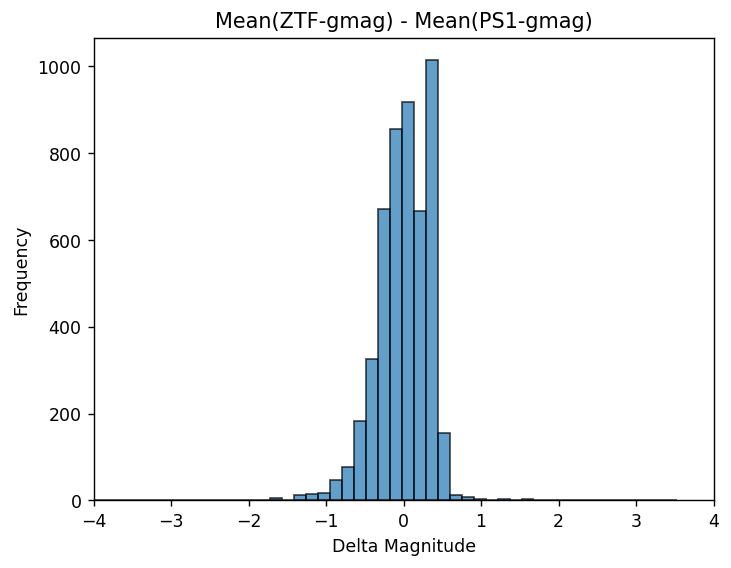

In [26]:
import matplotlib.pyplot as plt

plt.figure(dpi=125)
plt.hist(meandiff["meandiff"], bins=50, alpha=0.7, edgecolor="k")

plt.title("Mean(ZTF-gmag) - Mean(PS1-gmag)")
plt.ylabel("Frequency")
plt.xlabel("Delta Magnitude")
plt.xlim(-4,4)